In [1]:
# Install required packages
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from fastbook import *

In [ ]:
# The Original DataSet is available at: https://huggingface.co/datasets/jonathan-roberts1/AID_MultiLabel/blob/main/README.md
# Since the dataset is in .parquet format, I converted it to dataframes and created a csv file
# with just the image_id and the labels column.
dataset = "https://huggingface.co/datasets/jonathan-roberts1/AID_MultiLabel"

import pandas as pd
import os
import fastparquet

# Read the Parquet file efficiently using chunks
parquet_file = "<YOUR-DOWNLOADED-PATH>/aid_multilable.parquet"
chunksize = 1000  # Adjust chunk size as needed


# Open the ParquetFile object directly
pf = fastparquet.ParquetFile(parquet_file)

# Output CSV file and image directory
output_csv = 'output.csv'
image_dir = 'images'
os.makedirs(image_dir, exist_ok=True)  # Create image directory if it doesn't exist

# Iterate through chunks using iter_row_groups
image_id = 1
with open(output_csv, 'w', newline='') as csvfile:  # Open CSV file in append mode
    for chunk in pf.iter_row_groups():
        # Add image_id column with auto-incremented values
        chunk['image_id'] = [f"image_{image_id + i}.jpg" for i in range(len(chunk))]

        # Extract image bytes and save to files
        for index, row in chunk.iterrows():
            # print(index, row)
            image_bytes = row['image.bytes']  # Assuming image data is in 'image_data' column
            image_path = os.path.join(image_dir, row['image_id'])
            with open(image_path, 'wb') as f:
                f.write(image_bytes)

        # Append chunk to CSV file
        chunk.to_csv(csvfile, mode='a', header=not os.path.exists(output_csv), index=False)

        image_id += len(chunk)

In [3]:
from fastai.vision.all import *
path = "/kaggle/input/jonathan-roberts1-aid-multilabel-clean/output_final.csv"

In [4]:
df = pd.read_csv(path)

In [5]:
df.head()

,Unnamed: 0,label,image_id
0,0,"[0, 1, 2, 3, 8, 10, 15]",image_2.jpg
1,1,"[0, 2, 3, 8, 10]",image_3.jpg
2,2,"[0, 1, 2, 3, 8, 10]",image_4.jpg
3,3,"[0, 1, 2, 3, 8, 10]",image_5.jpg
4,4,"[0, 2, 3, 8, 10, 15]",image_6.jpg


In [6]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
df.head()

,label,image_id
0,"[0, 1, 2, 3, 8, 10, 15]",image_2.jpg
1,"[0, 2, 3, 8, 10]",image_3.jpg
2,"[0, 1, 2, 3, 8, 10]",image_4.jpg
3,"[0, 1, 2, 3, 8, 10]",image_5.jpg
4,"[0, 2, 3, 8, 10, 15]",image_6.jpg


In [8]:
df.shape

(2999, 2)

In [12]:
dblock = DataBlock()
dsets = dblock.datasets(df)
len(dsets.train), len(dsets.valid)

(2400, 599)

In [13]:
x,y = dsets.train[0]
x, y

(label       [1, 2, 8, 10, 15]
 image_id       image_2538.jpg
 Name: 2536, dtype: object,
 label       [1, 2, 8, 10, 15]
 image_id       image_2538.jpg
 Name: 2536, dtype: object)

In [14]:
path = "/kaggle/input/jonathan-roberts1-aid-multilabel-clean/images/images/"

In [66]:
import os

def get_x(r): return (os.path.join(path, r['image_id']))
def get_y(r): return eval(r['label'])
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('/kaggle/input/jonathan-roberts1-aid-multilabel-clean/images/images/image_2006.jpg',
 [2, 3, 6, 10, 12, 13])

In [29]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   get_x=get_x,
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=600x600,
 TensorMultiCategory([0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.]))

In [30]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#6) [1,2,3,8,10,15]

In [78]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df, bs=32)
# dblock.summary(os.path.join(path, 'images'))
len(dls.train), len(dls.valid)

(75, 19)

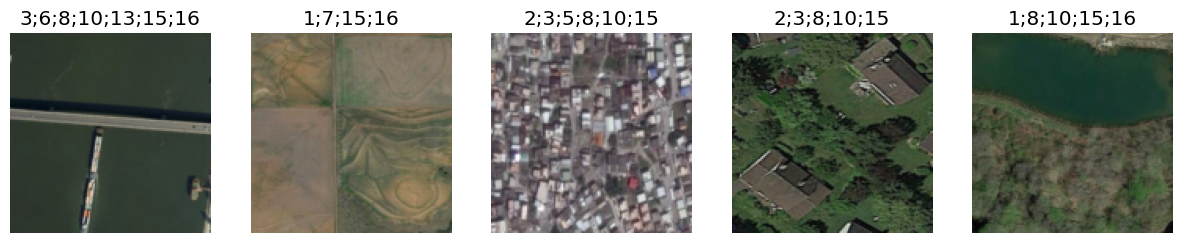

In [79]:
dls.show_batch(nrows=1, ncols=5)


In [80]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [35]:
# learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
# learn.fine_tune(8, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.932839,0.783900,0.430325,00:14
1,0.788009,0.585624,0.493470,00:14
2,0.613832,0.372147,0.747029,00:14
3,0.425808,0.221991,0.895807,00:14


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.215057,0.225213,0.907100,00:15
1,0.199115,0.209552,0.910046,00:15
2,0.183999,0.206545,0.916037,00:15
3,0.166506,0.178158,0.924482,00:15
4,0.148246,0.191333,0.923893,00:15
5,0.133678,0.174300,0.926446,00:15
6,0.120538,0.169590,0.927526,00:15
7,0.115131,0.185060,0.928999,00:15


In [75]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.3))
learn.fine_tune(12, base_lr=1e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.750365,0.760190,0.741825,00:40
1,0.382556,0.579379,0.868113,00:40
2,0.343460,0.490915,0.874104,00:40
3,0.317368,0.312908,0.891879,00:40


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.288864,0.313645,0.893941,00:49
1,0.295536,0.429132,0.898851,00:49
2,0.282995,0.325509,0.899244,00:50
3,0.266151,0.362373,0.906904,00:50
4,0.290186,0.428340,0.902779,00:50
5,0.293526,0.379034,0.901502,00:50
6,0.264392,0.561210,0.901895,00:49
7,0.258710,0.428631,0.915251,00:49
8,0.263416,0.504997,0.912305,00:50
9,0.276630,1.705455,0.905922,00:50


In [51]:
learn.export()

In [52]:
def map_class_names(code):
    """Maps a numerical code to its corresponding class name.

    Args:
        code: The numerical code to map (e.g., '0', '1', ...)

    Returns:
        The class name associated with the code.
    """

    mapping = {
        '0': "airplane",
        '1': "bare soil",
        '2': "buildings",
        '3': "cars",
        '4': "chaparral",
        '5': "court",
        '6': "dock",
        '7': "field",
        '8': "grass",
        '9': "mobile home",
        '10': "pavement",
        '11': "sand",
        '12': "sea",
        '13': "ship",
        '14': "tanks",
        '15': "trees",
        '16': "water",
    }

    class_name = mapping.get(code, "Unknown class")

    return class_name

In [53]:
map_class_names(str(14))

'tanks'

In [65]:
learn_inf = load_learner('/kaggle/working/export.pkl')
pred, idx, probs = learn_inf.predict('/kaggle/input/mix-set/c2.jpeg')
result = []
for i in pred:
    result.append(map_class_names(str(i)))
print(result)

['bare soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']
